# Treinamento e otimização da Rede Neural

Este notebook se refere às etapas de treinamento e otimização da rede neural, a partir do banco de dados já tratados pelo notebook 'tratamento_de_dados.ipynb' que tem como objetivo prever o band gap de um material 2D como trabalho final da disciplina de Redes Neurais e Algorítmos Genéticos da Ilum - Escola de ciência. 

## Bibliotecas
Aqui, vamos importar todas as bibliotecas que usaremos no treinamento e otimização de nossa rede neural.

In [1]:
import pandas as pd
import re
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from optuna import create_study, Trial

Definindo algumas variáveis que devem se manter constantes ao longo do código:

In [2]:
# Definindo número de features
num_dados_de_entrada = 69

# Definindo número de targets
num_dados_de_saida = 1

# Quantas vezes iremos rodar o optuna
NUM_TENTATIVAS = 110

# 10% dos dados gerais para separados para teste
TAMANHO_TESTE = 0.1

# 10% dos dados do treino para validação do modelo
TAMANHO_VALIDACAO = 0.1

# Semente aleatória
SEMENTE_ALEATORIA = 13

NUM_EPOCAS = 55

## DataModule

Implementamos o Data Module que é responsável por carregar e preparar os dados para treinamento, validação e teste da rede neural.

In [3]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        tamanho_lote=256,
        num_trabalhadores=2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

    def prepare_data(self):

        pd.read_csv("dataset_tratado.csv")

    def setup(self, stage):

        features = ["Thermodynamic stability level", "Energy", "Work function", "Heat of formation", "Space group number", "Volume of unit cell", "Electronegativity", "Be", "As", "O", "Ca", "Fe", "S", "In","Se","Sc","V","Zr","B","H","Te","Al","Mg","Ba","Pb","Mn","Si","Cr","Br","Ga","Hf","Ge","Ti","C","I","Li","Cl","Sr","Na","Nb","Ni","Ta","Pd","Pt","Tl","W","Sb","N","Cd","Cu","Sn","F","P","Ag","Au","Bi","Co","Zn","Rb","Os","Hg","Ir","Mo","Re","Rh","Ru","Y","Cs","K"]
        target = ["Band gap"]

        df = pd.read_csv("dataset_tratado.csv")
        
        df = df.reindex(features + target, axis=1)
        df = df.dropna()
        
        indices = df.index
        indices_treino_val, indices_teste = train_test_split(
            indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
        )

        df_treino_val = df.loc[indices_treino_val]
        df_teste = df.loc[indices_teste]

        indices = df_treino_val.index
        indices_treino, indices_val = train_test_split(
            indices,
            test_size=TAMANHO_TESTE,
            random_state=SEMENTE_ALEATORIA,
        )

        df_treino = df.loc[indices_treino]
        df_val = df.loc[indices_val]
        
        X_treino = df_treino.reindex(features, axis=1).values
        y_treino = df_treino.reindex(target, axis=1).values

        self.x_scaler = MaxAbsScaler()
        self.x_scaler.fit(X_treino)

        self.y_scaler = MaxAbsScaler()
        self.y_scaler.fit(y_treino)

        if stage == "fit":
            X_val = df_val.reindex(features, axis=1).values
            y_val = df_val.reindex(target, axis=1).values

            X_treino = self.x_scaler.transform(X_treino)
            y_treino = self.y_scaler.transform(y_treino)

            X_val = self.x_scaler.transform(X_val)
            y_val = self.y_scaler.transform(y_val)

            self.X_treino = torch.tensor(X_treino, dtype=torch.float32)
            self.y_treino = torch.tensor(y_treino, dtype=torch.float32)

            self.X_val = torch.tensor(X_val, dtype=torch.float32)
            self.y_val = torch.tensor(y_val, dtype=torch.float32)

        if stage == "test":
            X_teste = df_teste.reindex(features, axis=1).values
            y_teste = df_teste.reindex(target, axis=1).values

            X_teste = self.x_scaler.transform(X_teste)
            y_teste = self.y_scaler.transform(y_teste)

            self.X_teste = torch.tensor(X_teste, dtype=torch.float32)
            self.y_teste = torch.tensor(y_teste, dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

## Criando a rede neural com PyTorch Lightning

Utilizando PyTorch Lightning para treinar uma rede neural MLP (Multi-Layer Perceptron). Ele simplifica o desenvolvimento e treinamento de redes neurais.

Repare: aqui, já vizemos algumas alterações na classe MLP para preparar tal código para a otimização de hiperparâmetros.

In [4]:
class MLP(L.LightningModule):
    def __init__(
        self, num_camadas, num_neuronios, funcao_de_ativacao, otimizador, taxa_de_aprendizado, num_dados_entrada, num_targets
    ):
    
        super().__init__()
        
        camadas = []
        
        camadas.append(nn.Linear(num_dados_entrada, num_neuronios))
        camadas.append(funcao_de_ativacao)
        
        for _ in range(num_camadas-1):
            camadas.append(nn.Linear(num_neuronios, num_neuronios))
            camadas.append(funcao_de_ativacao)
            
        camadas.append(nn.Linear(num_neuronios, num_targets))
        
        
        self.todas_camadas = nn.Sequential(*camadas)
        
        self.otimizador = otimizador
        self.taxa_de_aprendizado = taxa_de_aprendizado

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.todas_camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        if self.otimizador == "SGD":
            optimizer = optim.SGD(self.parameters(), lr=self.taxa_de_aprendizado)
        elif self.otimizador == "ADAM":
            optimizer = optim.Adam(self.parameters(), lr=self.taxa_de_aprendizado)
        elif self.otimizador == "RMSPROP":
            optimizer = optim.RMSprop(self.parameters(), lr=self.taxa_de_aprendizado)
            
        return optimizer

## Otimização de hiperparâmetros  (Optuna)

Utilizando Optuna para encontrar os melhores hiperparâmetros para nossa rede neural MLP, o Optuna simplifica a busca pelos melhores hiperparâmetros, nos permitindo testar diferentes arquiteturas. <br>
Testamos 110 arquiteturas.

O script com o código do optuna está disponível no arquivo `otimizacao_dos_hiperparametros.py` no github.

#### Após rodado na GPU, O melhor trial foi:

Número de neuronios: 84 <br>
Número de camadas: 4 <br>
Função de ativação: ELU<br>
Taxa de aprendizado: 0.005203233741448786<br>
Otimizador: ADAM


* `Atenção`: Caso queire ver todos os 110 trials feitos pelo optuna consulte o arquivo `trials_job_1516.out`.

In [7]:
melhor_model_gpu = MLP(num_camadas = 4, num_neuronios = 84, funcao_de_ativacao = nn.ELU(), otimizador = 'ADAM', taxa_de_aprendizado = 0.005203233741448786, num_dados_entrada = num_dados_de_entrada, num_targets = num_dados_de_saida)

Agora, vamos treinar nossa rede com nosso melhor trial. E vamos análisar qual a melhor quantidade de épocas, para isso vamos treinar a rede com 100 épocas e plotar a curva de aprendizado e assim escolher um número de épocas racionalmente razoável.

In [8]:
# criando um treinador
treinador = L.Trainer(max_epochs=100)

# Criando uma instância da classe DataModule.
dm = DataModule()

t0 = time.time()

treinador.fit(melhor_model_gpu, dm)

tf = time.time()
print(f'{tf - t0} segundos')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | todas_camadas | Sequential | 27.4 K
---------------------------------------------
27.4 K    Trainable params
0         Non-trainable params
27.4 K    Total params
0.110     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


1174.519911289215 segundos


Cálculo do RMSE:

In [9]:
melhor_model_gpu.eval()
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = melhor_model_gpu(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(RMSE)

0.8110667560020441


Plotando a curva de aprendizado para 100 épocas:

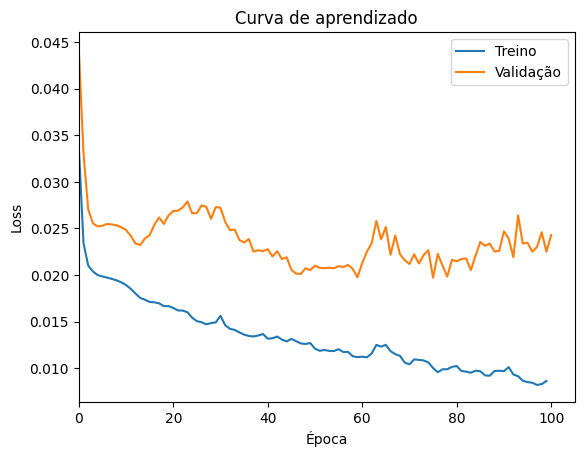

In [10]:
figura, eixo = plt.subplots()

ca_treino = melhor_model_gpu.curva_aprendizado_treino
ca_val = melhor_model_gpu.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

Agora sim! Podemos achar um números de épocas racionalmete razoável, que é por volta de 57 épocas. Isso, porque a partir desse número a validação começa a se afastar do treino - o que indica o overfitting da rede.


## Rede padrão ouro
Agora vamos treinar nossa rede com os melhores cenários que encontramos: tanto dos hiperparâmetros quanto o número de épocas.

In [11]:
model_padrao_ouro = MLP(num_camadas = 4, num_neuronios = 84, funcao_de_ativacao = nn.ELU(), otimizador = 'ADAM', taxa_de_aprendizado = 0.005203233741448786, num_dados_entrada = num_dados_de_entrada, num_targets = num_dados_de_saida)

In [12]:
# criando um treinador
treinador = L.Trainer(max_epochs=57)

# Criando uma instância da classe DataModule.
dm = DataModule()

t0 = time.time()

treinador.fit(model_padrao_ouro, dm)

tf = time.time()
print(f'{tf - t0} segundos')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | todas_camadas | Sequential | 27.4 K
---------------------------------------------
27.4 K    Trainable params
0         Non-trainable params
27.4 K    Total params
0.110     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\venv\ilumpy\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=57` reached.


703.852949142456 segundos


Aferindo, através do RMSE, o quão bom o modelo final é:

In [13]:
model_padrao_ouro.eval()
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = model_padrao_ouro(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(RMSE)

0.7577510517773061


Salvando apenas os pesos e vieses da rede neural em um arquivo, para caso necessite no futuro. Utilizamos o módulo pickle.

In [14]:
nome_arquivo = "modelo_final_BG.p"
pickle.dump(model_padrao_ouro.state_dict(), open(nome_arquivo, "wb"))

# Referências

1. CASSAR, D. R. PyTorch Lightning. (2024)
2. CASSAR, D. R.Treinando uma rede neural com pytorch. (2024)
3. CASSAR, D. R. Redes neurais artificiais do zero em Python. (2024)
4. CASSAR, D. R. Avaliação de modelos: a estratégia de divisão entre treino e teste. (2023)
5. CASSAR, D. R. Transformação e normalização. (2023)
6. CASSAR, D. R. Conversão simbólico-numérico. (2023)
7. Optuna: A hyperparameter optimization framework — Optuna 2.10.0 documentation. Disponível em: <https://optuna.readthedocs.io/en/stable/index.html>.
10. ChatGPT para ajuda na resolução de bugs.